<a href="https://colab.research.google.com/github/sosanzma/Simpson_Generation_withGANs/blob/main/Trabajo_simpson_faces_generation_with_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Aprendizaje Profundo 

## Generación de Caras de  simpson via DCGAN 

### Manel Soler , Manuel Jiménez, Sergio Conde y Oriol Chacón

En este código se presenta una aplicación de generación de caras utilizando un DCGAN. En nuestro caso, hemos importado de un data set de Kaggle que  contenia unas 10.000 caras de personajes de los Simpson. 

En el mismo repositorio se aportaban códigos de usuarios intentando generar caras con estos datos de entrenamiento. vimos que los resultados no eran muy buenos y decidimos intentarlo nosotros. 

No hemos usado ninguno de esos códigos, si no que hemos aplicado un código utilizado en otro repositorio de Kaggle para la generación de retratos. 

Enlace para ver códigos de generación de Caras de lo simpson : 

[Simspon_faces_code](https://www.kaggle.com/datasets/kostastokis/simpsons-faces/code)

[Articulo](https://medium.com/@jasonsalas_89883/recreating-the-simpsons-with-a-dcgan-2122f788faea)

In [ ]:
from __future__ import print_function

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import math, os, random, cv2
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0006

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#id of the model to save
idmodel=14

In [ ]:
! pip3 install torchgan

     |████████████████████████████████| 71 kB 29 kB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=512e7d5ed715f8b5cd390e77f9f1356afb66a543917b76b075eaa33b4fb8c9d9
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


# Importación de datos desde Kaggle

Vamos a importar los datos directemante desde kaggle utilianzdo  un **API Token** generado por kaggle para cada usuario.

In [ ]:
from torchgan.layers import VirtualBatchNorm,MinibatchDiscrimination1d

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
 ! pip install -q kaggle

Importamos el archivo .json con nuestras credenciales

In [ ]:
 from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manelsoler","key":"d329fcb9935f0d4c583415fbde0b65dd"}'}

In [ ]:
! mkdir ~/.kagle

! cp kaggle.json ~/.kagle/


In [ ]:
! chmod 600 ~/.kagle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           7640       1013  0.9375           
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           5064        130  1.0              
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1478        831  0.875            


Ahora descargamos el data set que estamos interesados en cuestión :

[Enlace al data set](https://www.kaggle.com/datasets/kostastokis/simpsons-faces)

In [ ]:
! kaggle datasets download -d kostastokis/simpsons-faces


 96% 423M/442M [00:04<00:00, 85.6MB/s]
100% 442M/442M [00:04<00:00, 108MB/s] 


In [ ]:
! unzip simpsons-faces.zip 

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: simplified/5389.png     
  inflating: simplified/539.png      
  inflating: simplified/5390.png     
  inflating: simplified/5391.png     
  inflating: simplified/5392.png     
  inflating: simplified/5393.png     
  inflating: simplified/5394.png     
  inflating: simplified/5395.png     
  inflating: simplified/5396.png     
  inflating: simplified/5397.png     
  inflating: simplified/5398.png     
  inflating: simplified/5399.png     
  inflating: simplified/54.png       
  inflating: simplified/540.png      
  inflating: simplified/5400.png     
  inflating: simplified/5401.png     
  inflating: simplified/5402.png     
  inflating: simplified/5403.png     
  inflating: simplified/5404.png     
  inflating: simplified/5405.png     
  inflating: simplified/5406.png     
  inflating: simplified/5407.png     
  inflating: simplified/5408.png     
  inflating: simplified/5409.png     
  inflating: simplified/541

# Visualización

Creamos una función que nos permitirá visualizar las imagenes de entrenamiento y las imagenes generadas

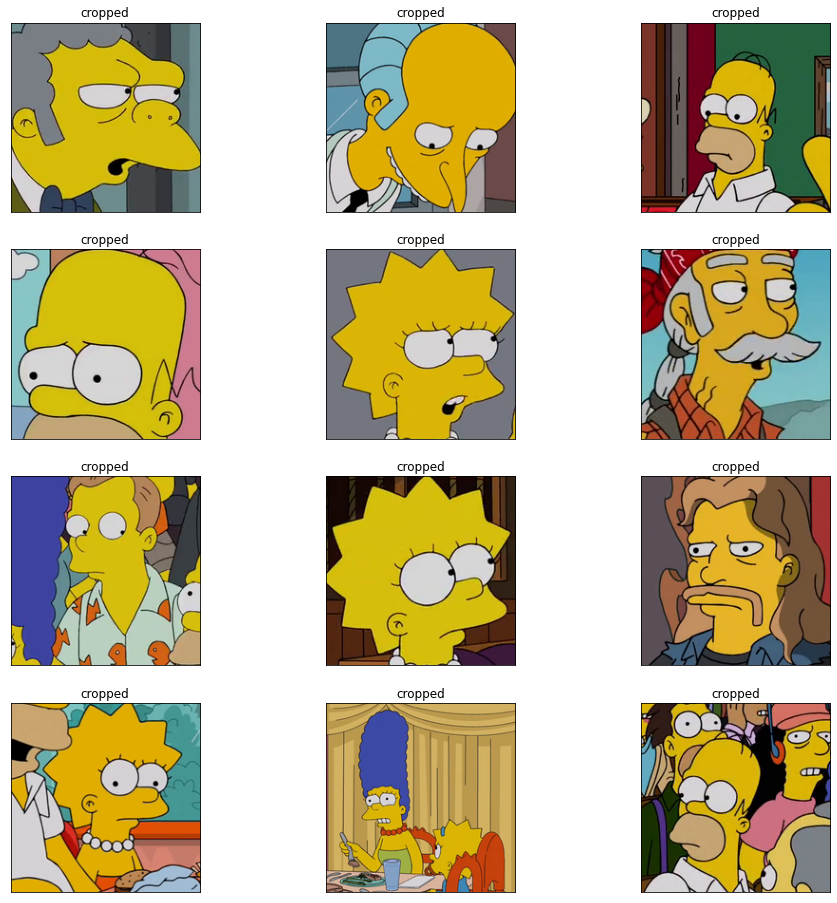

In [ ]:
#from:https://www.kaggle.com/ihelon/monet-eda
def vis(path, n_images, is_random=True, figsize=(16, 16)):
    plt.figure(figsize=figsize)
    
    w = int(n_images ** .5)
    h = math.ceil(n_images / w)
    
    image_names = os.listdir(path)
    
    for i in range(n_images):
        image_name = image_names[i]
        if is_random:
            image_name = random.choice(image_names)
            
        img = cv2.imread(os.path.join(path, image_name))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.subplot(h, w, i + 1)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.normpath(path)))
        plt.xticks([])
        plt.yticks([])
    
    plt.show()
    

BASE_PATH = "/content/cropped"
portrait_paint        = os.path.join(BASE_PATH,"")

vis(portrait_paint, 12, is_random=True)

# Dataloader

Las imagenes que importamos tienes 200x200 de tamaño. Este tamaño es demasiado grande para la poca potencia de procesamiento gráfico que disponemos. Utilizaremos la la función de pytorch `ImageFolder` la cual genera un *data loader* generico donde las imagenes son guardadas en un *root*.  Esta función tiene la opción de transformar las imagenes con el metodo `Resize`y de normalizarlas `Normalize`.

Nosotros vamos a utilizar `image_size = 64` porque es el valor que más se ha repetido en los códigos que hemos consultado

Después generaremos batches de 64 imagenes. El algoritmo se entrenará para intentar generar batches de la misma forma, es decir, intentar generar una matriz de 64 fotos (8x8)

In [ ]:
from distutils.dir_util import copy_tree
copy_tree('/content/cropped',"simpsons/images")


['simpsons/images/843.png',
 'simpsons/images/4075.png',
 'simpsons/images/5317.png',
 'simpsons/images/7528.png',
 'simpsons/images/7519.png',
 'simpsons/images/4446.png',
 'simpsons/images/3262.png',
 'simpsons/images/6534.png',
 'simpsons/images/1273.png',
 'simpsons/images/1902.png',
 'simpsons/images/605.png',
 'simpsons/images/6617.png',
 'simpsons/images/5594.png',
 'simpsons/images/7155.png',
 'simpsons/images/6467.png',
 'simpsons/images/5010.png',
 'simpsons/images/8004.png',
 'simpsons/images/8363.png',
 'simpsons/images/7726.png',
 'simpsons/images/3051.png',
 'simpsons/images/2622.png',
 'simpsons/images/4960.png',
 'simpsons/images/7484.png',
 'simpsons/images/1211.png',
 'simpsons/images/7238.png',
 'simpsons/images/9506.png',
 'simpsons/images/3860.png',
 'simpsons/images/2589.png',
 'simpsons/images/3890.png',
 'simpsons/images/658.png',
 'simpsons/images/7055.png',
 'simpsons/images/3814.png',
 'simpsons/images/1087.png',
 'simpsons/images/5245.png',
 'simpsons/images

In [ ]:

root_path="simpsons"

dataset = dset.ImageFolder(root=root_path,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers,drop_last=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
device

device(type='cuda', index=0)

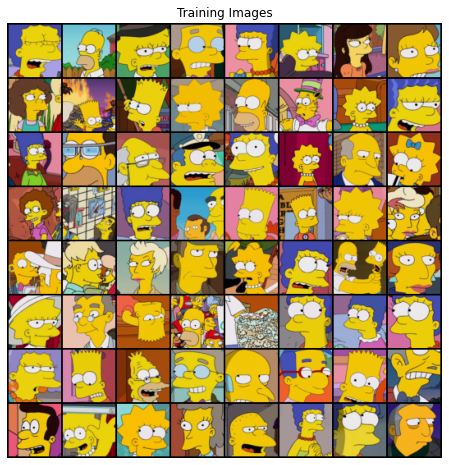

In [ ]:

# representamos un batch

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

#  Inicialización de los pesos

Para la inicialización de pesos se ha demostrado que utilizar distribuciones normales de la forma, $\mathcal{N}(0,0.02)$, en las capas convolucionales, mejora los resultados (https://arxiv.org/pdf/1511.06434.pdf). Para las capas de Batch Normalization se utilizará una distribución $\mathcal{N}(1,0.02)$, con 0 bias.

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generador

El generador está compuesto por 5 bloques formados por una capa Convolucional Traspuesta 2D ($4\times 4$), una de Batch Normalization y una ReLu; excepto por el último bloque, que acaba con una Tanh.

El input es un vector de ruido aleatorio de 100 elementos, que tras los 5 bloques de convolucionales traspuestas y su respectivo padding acabará siendo una imagen de $64\times 64$ y tres canales.

Para cada convolucional los argumentos son nn.ConvTranspose2d(`in_channels`, `out_channels`, `kernel_size`, `stride`, `padding`, `bias`). El padding que cada capa de este tipo ejerce sobre una imagen de entrada de dimensiones ($X \times X\times$`in_channels`) sigue la fórmula:

<center> $(O,O,\mathrm{out\_channels})$ with $O=(X-1)\times \mathrm{stride} - 2 \times \mathrm{padding} + (\mathrm{kernel\_size} - 1) +1$ </center>

 nn.ConvTranspose2d(`in_channels`, `out_channels`, `kernel_size`, `stride`, `padding`, `bias`)

Generador : 


Input estado 1 : 1 x 100 (ruido) 

Input estado 2 : 512 x 4 x 4 .

Input estado 3 : 256 x 8 x 8 .

Input estado 4 : 128 x 16 x 16 .

Input estado 5 : 64 x 32 x 32 .

Output estado 5 : 3 x 64 x 64 . // es la imagen que genera el generador y que le pasaremos como input a el discriminador

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminador

Simétricamente está construido el discriminador, que toma imágenes de $3\times 64 \times 64$, y tras 5 bloques de `Conv2d` $+$ `BatchNorm2d` $+$ `LeakyReLu`, obtenemos un output de $1 \times 1 \times 1$ con una sigmoide de activación. 

Las conv2D tienen padding = 1, añadiendo 0 a dichas filas. Finalmente, se obtiene un vector de $ 4096 \times 1$, al que se le aplica una función lineal y una sigmoide para obtener el output (mentionned in *Improved Techniques for Training GANs*, Salimans et al., 2016, https://arxiv.org/pdf/1606.03498.pdf)

**Discriminador :**

Input estado 1 : 3 x 64 x 64 . 

Input estado 2 : 64 x 32 x 32 .

Input estado 3 : 128 x 16 x 16 .

Input estado 4 : 256 x 8 x 8 .

Input estado 5 : 512 x 4 x 4 .

Output del estado 5 : 1024 x 2 x 2.

**Después de este proceso :** 

Main 2: 4096 x 1

Output final: 1 x 1


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            #nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False)
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            # state size. (ndf*16) x 2 x 2
        )
        self.main2 = nn.Sequential(
            nn.Linear(4096+128,1),
            nn.Sigmoid()
        )
        self.minibatchdis=nn.Sequential(
            MinibatchDiscrimination1d(in_features =4096,out_features =128,intermediate_features =16),
        )
    def forward(self, input,matching = False):
        output = self.main(input)
        feature = output.view(-1,4096)
        #output = self.main2(feature)
        
        output = output.view(-1,4096)        
        output=self.minibatchdis(output)
        output=self.main2(output)
        
        if matching == True:
            return feature,output
        else:
            return output #batch_size x 1 x 1 x 1 => batch_size

In [ ]:
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

# Entrenamiento


utilizaremos la funcion coste de `Binary Cross entropy` con los parámetros por defecto.


Los optimizadores usados son `Adam` para las dos redes, para la elección del `learning rate` hemos cogido el que estaba por defecto, pues atendiendo al pequeño número de épocas no le hemos dado importancia.

El parámetro $\beta_1$  es $0.5$ de acuerdo a como se referanciava a traves de   https://arxiv.org/pdf/1511.06434.pdf. En cuanto al  parámetro  $\beta_2$ hemos dejado el parámetro por defecto


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()
criterionG = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
#Using one-sided-label smoothing, we choose 0.85 as real_label
real_label = 0.85
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

schedulerD = optim.lr_scheduler.StepLR(optimizerD, step_size=int(num_epochs/4), gamma=0.5)
schedulerG = optim.lr_scheduler.StepLR(optimizerG, step_size=int(num_epochs/4), gamma=0.5)

La función  de `Binary Cross Entroy Loss` computa en cada input de cada batch:

$l=-[y.\mathrm{log}(O) + (1-y).\mathrm{log}(1-O)]$

siendo $O$ el output de cada red considerada. :

1. En el *Discriminador* `errD_real` con salida $O=D(x)$ sinedo $x$ la imagen real con etiqueta $y=1$ ---> $l=-\mathrm{log}(D(x))$. 


Es decir, en el proceso de entrenamiento, cuando la imagen pasada al discriminador sea real, el error será : 
 $l=-\mathrm{log}(D(x))$ De forma que si la salida es 1 (real) el error es 0, y si la salida es ~ 0 el error sera alto.


2. En el *Discriminador* `errD_fake`con salida $O=D(G(z))$ del $G$  generador, y $z$ siendo el ruido  aleatorio  que recibe como entrada el generador con etiqueta $y=0$ ---> $l=-\mathrm{log}(1-D(G(z)))$

Este es el error que comete el discriminador con las fake_imagenes. Cuando el discriminador predice 0 (falsa), el error es 0.


3. Para el *Generador* `errG` con salida $O=D(G(z))$ y etiqueta $y=1$ ---> $l=-\mathrm{log}(D(G(z)))$

Queremos que el la prediccion del discriminador sea 1(verdadera) para imagenes sintéticas, eso significa que el generador hace buenas imagnenes. De modo que cuanto mas próximo a 1 sea $D(G(z))$ menor sera el error del generador 

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_G_z1s=[]
D_G_z2s=[]
D_xs=[]
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        
        # Calculate gradients for D in backward pass
        errD_real.backward()
        
        #Calculate the mean value of D(x) with x real images
        D_x = output.mean().item()

              
        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise) #generating the fake images
        label.fill_(fake_label) #replace the content of the previous label variable

        # Forward pass fake batch through D
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch
        errD_fake.backward()
        
        #Calculate the mean value of D(G(z)) with G(z) generated image
        D_G_z1 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad() #reset G gradient
        label.fill_(real_label)  # fake labels are real for generator cost
        
        ##Feature matching
        feature_real,_=netD(real_cpu,matching=True)
        feature_fake,output=netD(fake,matching=True)
        feature_real=torch.mean(feature_real,0)
        feature_fake=torch.mean(feature_fake,0)
        
        errG=criterionG(feature_fake,feature_real.detach())
        
        # Perform another forward pass of all-fake batch through D
        #output = netD(fake).view(-1)
        
        # Calculate G's loss based on this output
        errG += criterion(output.view(-1), label)
        
        # Calculate gradients for G
        errG.backward()
        
        #Calculate the mean value of D(G(z)) with G(z) generated image
        output = netD(fake).view(-1)        
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        D_G_z1s.append(D_G_z1)
        D_G_z2s.append(D_G_z2)
        D_xs.append(D_x)      
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
    schedulerG.step()
    schedulerD.step()

Se han truncado las últimas 5000 líneas del flujo de salida.
[67/100][82/154]	Loss_D: 0.4355	Loss_G: 4.9991	D(x): 0.8189	D(G(z)): 0.0028 / 0.0031
[67/100][83/154]	Loss_D: 0.4333	Loss_G: 4.6177	D(x): 0.8263	D(G(z)): 0.0045 / 0.0051
[67/100][84/154]	Loss_D: 0.4304	Loss_G: 5.2007	D(x): 0.8490	D(G(z)): 0.0026 / 0.0025
[67/100][85/154]	Loss_D: 0.4529	Loss_G: 5.2534	D(x): 0.9119	D(G(z)): 0.0061 / 0.0023
[67/100][86/154]	Loss_D: 0.4441	Loss_G: 5.3743	D(x): 0.7784	D(G(z)): 0.0012 / 0.0021
[67/100][87/154]	Loss_D: 0.4346	Loss_G: 4.5768	D(x): 0.8616	D(G(z)): 0.0059 / 0.0051
[67/100][88/154]	Loss_D: 0.4344	Loss_G: 5.4299	D(x): 0.8821	D(G(z)): 0.0034 / 0.0019
[67/100][89/154]	Loss_D: 0.4485	Loss_G: 4.5510	D(x): 0.7735	D(G(z)): 0.0030 / 0.0053
[67/100][90/154]	Loss_D: 0.4325	Loss_G: 4.5173	D(x): 0.8460	D(G(z)): 0.0045 / 0.0055
[67/100][91/154]	Loss_D: 0.4400	Loss_G: 4.2304	D(x): 0.8641	D(G(z)): 0.0129 / 0.0076
[67/100][92/154]	Loss_D: 0.4476	Loss_G: 5.4366	D(x): 0.9051	D(G(z)): 0.0056 / 0.0019
[67/

# Resultados

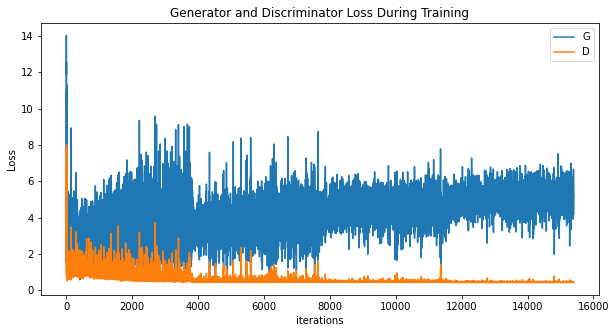

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Vemos como el error del discriminador se reduce practicamente a cero rapidamente, lo que repercute negativamente en nuestro generador, que podemos ver como se frena su aprendizaje rapidamente.

Sería interesante intentar mejorar este desvanecimiento del gradiente del discriminador. Hemos intentado mejorar solucionar este aspecto utilizando las funciones de activación `LeakyRelu`, aumentando el batch y normalizando las immágenes entre $[-1,1]$. Pero no hemos conseguido que mejorase más que lo presentado.

Hemos decidido, pese  que no hay mejora por parte del generador a realizar este número de iteraciones , porqué a nuestro parecer, las imagenes eran mejores con 100 épocas que con un número inferior. Entendiendose *mejores* como una representación más verosimil de los personajes de los Simpson 

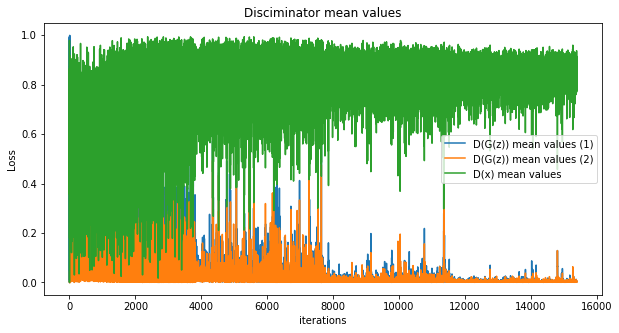

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Disciminator mean values")
plt.plot(D_G_z1s,label="D(G(z)) mean values (1)")
plt.plot(D_G_z2s,label="D(G(z)) mean values (2)")
plt.plot(D_xs,label="D(x) mean values")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

(1) actualización del Discriminador

(2) actualización del Generador

Vemos como para imagenes reales, el valor medio de las predicciones del Discriminador converge a 1. De la misma forma, cuando $D$ es alimentado con imagenes sintéticas $D(G(z))$  tiende a 0 en las dos acutalizaciones. 

En un caso ideal, la frontera entre las predicciones del discriminador para imágenes reales y sintéticas no debería estar tan separada. Esto ya lo podiamos adelantar en la imagen anterior, pues se observaba como el Discrimindor funcionaba demasiado bien como para que el generador pudiera proguesar

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# queremos gurdarlo
ani.save("test1.gif", writer='pillow')
HTML(ani.to_jshtml())

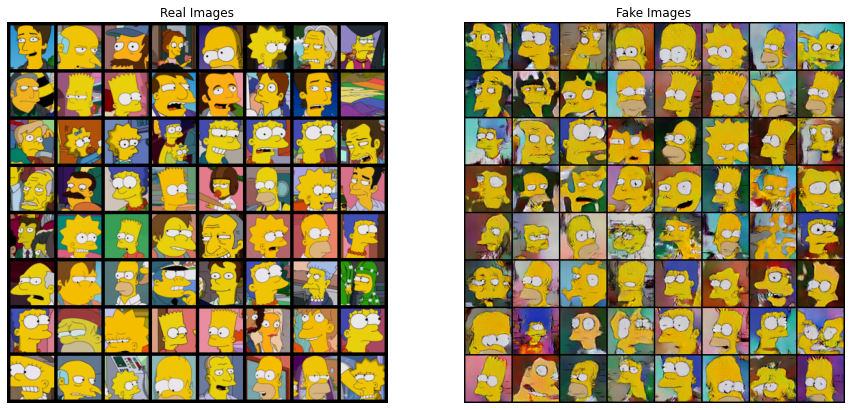

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Conclusiones

Tras ver los resultados, creemos que el data set estaba desbalanzeado con los personajes principales de la serie. Pues vemos que practicamnente todas las imagenes generedas son de  : *Homer, Lisa, Bart y Marge*.  Posiblemente este desbalanzeo de las imagenes haya sobreentrenado la red con estas imagenes y hemos perdido capacidad de generar otras caras, incluso caras nuevas. Si que vemos alguna combinación entre *Bart y Homer* en las segunda fila a la derecha, así como caras que no terminamos de conocer.

También se entiende  que la red ha aprendido a separar el contraste entre las caras y los fondos así como los rasgos carácterísticos de estos personajes e incluso es capaz de replicar las caras en algunas imagenes. 
